# chapter2 자연어와 단어의 분산 표현

## 2.1 자연어 처리란
- NLP: Natural Language Processing 자연어를 처리하는 분야
- 우리의 말을 컴퓨터에게 이해시키기 위한 기술

## 2.2 시소러스
- 시소러스 thesaurus: 유의어사전
- 뜻이 같은 단어(동의어) = 뜻이 비슷한 단어(유의어)
- 단어 네트워크를 이용해 컴퓨터에게 단어 사이의 관계 가르침

### 2.2.1 WordNet

### 2.2.2 시소러스의 문제점
- 시대 변화에 대응하기 어렵다
- 사람을 쓰는 비용은 크다
- 단어의 미묘한 차이를 표현할 수 없다

## 2.3 통계 기반 기법

### 2.3.1 파이썬으로 말뭉치 전처리하기

In [1]:
text = 'You say goodbye and I say hello.'

text = text.lower()
text = text.replace('.', ' .')
print(text)

words = text.split(' ')
print(words)

you say goodbye and i say hello .
['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


In [2]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word
        
print(id_to_word)
print(word_to_id)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [3]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [4]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [5]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


### 2.3.2 단어의 분산 표현
- 분산 표현: 단어의 의미를 정확하게 파악할 수 있는 벡터 표현

### 2.3.3 분포 가설
- 분포 가설: 단어의 의미는 주변 단어에 의해 형성된다
- 즉 단어 자체에는 의미가 없고 그 단어가 사용된 '맥락'이 의미 형성
- 맥락: 특정 단어를 중심에 둔 그 주변 단어
- 윈도우 크기: 맥락의 크기 (주변 단어를 몇 개나 포함할지)

### 2.3.4 동시발생행렬 co-occurrence matrix
- 그 주변에 어떤 단어가 몇 번이나 등장하는지를 세어 집계하는 방법 (통계기반)

In [6]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess

text = 'You say goodbye and i say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [7]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

In [8]:
vocab_size = len(word_to_id)
co_matrix = create_co_matrix(corpus, vocab_size)

co_matrix

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

### 2.3.5 벡터 간 유사도
- 벡터 사이의 유사도 측정 => 코사인 유사도 cosine similarity

### $ similarity(x, y) = {xy\over||x||||y|| } $

In [9]:
# devide by zero error !
def cos_similarity(x, y):
    nx = x / np.sqrt(np.sum(x**2))
    ny = y / np.sqrt(np.sum(y**2))
    return np.dot(nx, ny)

# + epsilon
def cos_similarity(x, y, eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    return np.dot(nx, ny)

In [10]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

0.7071067691154799


### 2.3.6 유사 단어의 랭킹 표시
##### most_similar(query, word_to_id, id_to_word, word_matrix, top=5)
- query: 검색어(단어)
- word_to_id: 단어에서 단어ID로의 딕셔너리
- id_to_word: 단어ID에서 단어로의 딕셔너리
- word_matirx: 단어벡터들을 한데 모은 행렬, 각 행에는 대응하는 단어의 벡터가 저장되어 있다고 가정
- top: 상위 몇 개까지 출력할지 결정

In [11]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    
    # 1. 검색어 꺼낸다
    if query not in word_to_id:
        print("%s(을)를 찾을 수 없습니다." %query)
        return
    
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    
    # 2. 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
        
    # 3. 코사인 유사도를 기준으로 내림차순 출력
    count = 0
    for i in (-1*similarity).argsort():   # 내림차순 index
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

In [12]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## 2.4 통계 기반 기법 개선하기

### 2.4.1 상호정보량
#### 점별 상호정보량 (Pointwise Mutual Information, PMI)
### $ PMI(x, y) = log_2{P(x,y)\over P(x)P(y) } $
- P(x): x가 일어날 확률
- P(y): y가 일어날 확률
- P(x, y): x와 y가 동시에 일어날 확률

#### 동시발생행렬 사용
### $ PMI(x, y) = log_2{P(x,y)\over P(x)P(y)} = log_2{{C(x, y)\over N}\over {{C(x) \over N} {C(y) \over N}}} = log_2{C(x,y)\cdot N\over C(x)C(y)} $
- N: 말뭉치에 포함된 단어
- C: 동시발생 행렬
- C(x, y): x와 y가 동시발생하는 횟수
- C(x), C(y): x, y의 등장 횟수

#### 양의 상호정보량 (Positive PMI, PPMI)
### $ PPMI(x, y) = max(0, PMI(x, y)) $
- PMI의 문제: 두 단어의 동시발생 횟수가 0이면 $log_20= -\infty$

In [13]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j]*N / (S[i]*S[j]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total // 100) == 0:
                    print('%.1f%% 완료' %(100*cnt/total))
                    
    return M

In [14]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)
print('동시 발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시 발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 2.4.2 차원 감소 Dimensionality reduction
- 중요한 정보는 최대한 유지하면서 차원 줄이기
- 특이값 분해 (Singular Value Decomposition, SVD)
### $ X = USV^T $


- U, V: 직교행렬, S: 대각행렬

### 2.4.3 SVD에 의한 차원 감소

In [18]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

U, S, V = np.linalg.svd(W)

print("동시발생행렬:", C[0])
print("PPMI행렬:", W[0])
print("SVD:", U[0])
print("2차원벡터로 줄이기:", U[0, :2])

동시발생행렬: [0 1 0 0 0 0 0]
PPMI행렬: [0.    1.807 0.    0.    0.    0.    0.   ]
SVD: [-3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01  0.000e+00  9.323e-01
  2.226e-16]
2차원벡터로 줄이기: [-3.409e-01 -1.110e-16]


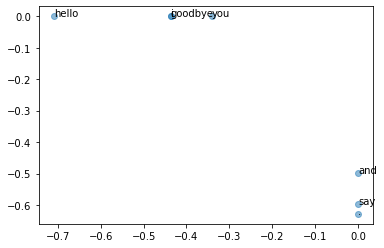

In [22]:
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()